### Instructions
This lecture is about gradient boosting.  The European Social Survey has surveyed people living in Europe various questions about their attitudes, beliefs and behavior patterns in an attempt to measure social attitudes and how they change over time.  Thinkful has provided a culled dataset with 13 features.  The guided exercise applies a gradient boosted tree classifier of 500 estimators and max depth of 2 to predict if a respondent has a partner or not.  The training set accuracy was 0.047 and test set accuracy was 0.0626, with error rates at ~0.18.  **I am tasked with reducing the error rates in the test set.**

Strategies they suggest employing include: 
1.  Feature engineering
2.  Apply overfitting-prevention strategies (i.e. subsampling, learning rate)
3.  Different loss functions
4.  Changing the structure of the weak learner

### 1 - Importing the Data
There are 13 features including the target variable, partner.  A description of the features are summarized below aside from year, which I could not find a description for. Otherwise, all features aside from country are numeric values.  Those with an asterisk (\*) are on a 0-10 scale, where 0 is the lowest value (i.e. you can't trust anyone) and 10 is the highest value (i.e. most people can be trusted).  A 77 is a refusal to answer, 88 means the respondent doesn't know, and 99 is no answer.  For the feature 'sclmeet', signified by two asterisks (\*\*), the values represent never meeting (1) to meeting everyday (7).  Finally, for 'sclact', signified by three asterisks (\*\*\*), the values correspond to much less than most (1) to much more than most (5), 7 is a refusal to answer, 8 means the respondent didn't know, and 9 means the respondent didn't answer.

| Feature | Description   |
|------|------|
|   cntry  | Country |
|   idno  | Identification number |
|   year  | |
|   tvtot  | The total amount of time the respondent watches tv on a weekday (Mon - Fri)|
|   ppltrst *  | How much trust the respondent had in other people |
|   pplfair *  | How much the respondent gets taken advantage of |
|   pplhlp *  | If the respondent thinks people are helpful |
|   happy *  |How happy the respondent is |
|   sclmeet **  | How often the respondent meets with friends, relatives, or colleagues |
|   sclact \***  | If the respondent attends social activities more or less than others of the same age|
|   gndr  | Gender of the respondent |
|   agea  | Age of the respondent|
|   partner  | If the respondent has a partner or not|

In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import time

import fancyimpute
from sklearn import ensemble
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report 
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from tabulate import tabulate
from scipy.stats.mstats import winsorize


C:\Users\Crystal\AppData\Local\Continuum\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
df = pd.read_csv('ESSdata_Thinkful.csv')

In [3]:
df.head()

,cntry,idno,year,tvtot,ppltrst,pplfair,pplhlp,happy,sclmeet,sclact,gndr,agea,partner
0,CH,5.0,6,3.0,3.0,10.0,5.0,8.0,5.0,4.0,2.0,60.0,1.0
1,CH,25.0,6,6.0,5.0,7.0,5.0,9.0,3.0,2.0,2.0,59.0,1.0
2,CH,26.0,6,1.0,8.0,8.0,8.0,7.0,6.0,3.0,1.0,24.0,2.0
3,CH,28.0,6,4.0,6.0,6.0,7.0,10.0,6.0,2.0,2.0,64.0,1.0
4,CH,29.0,6,5.0,6.0,7.0,5.0,8.0,7.0,2.0,2.0,55.0,1.0


There are about 8600 respondents, but some of the features are missing values.  Looking at the statistics of the features, most people watch 4 hours of tv during the weekday, are pretty happy, and feel ambivalent towards others (trust, fairness, helpfulness).  Interestingly enough, most people meet up for social gatherings once a week but believe they are less social than others.  

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8594 entries, 0 to 8593
Data columns (total 13 columns):
cntry      8594 non-null object
idno       8594 non-null float64
year       8594 non-null int64
tvtot      8586 non-null float64
ppltrst    8580 non-null float64
pplfair    8555 non-null float64
pplhlp     8569 non-null float64
happy      8563 non-null float64
sclmeet    8579 non-null float64
sclact     8500 non-null float64
gndr       8584 non-null float64
agea       8355 non-null float64
partner    8577 non-null float64
dtypes: float64(11), int64(1), object(1)
memory usage: 872.9+ KB


In [5]:
df.describe()

,idno,year,tvtot,ppltrst,pplfair,pplhlp,happy,sclmeet,sclact,gndr,agea,partner
count,8.594000e+03,8594.000000,8586.000000,8580.000000,8555.000000,8569.000000,8563.000000,8579.000000,8500.000000,8584.000000,8355.000000,8577.000000
mean,3.954938e+04,6.500000,3.861985,5.559907,6.005143,5.319874,7.694616,5.192563,2.748941,1.497204,47.470736,1.384867
std,6.267259e+05,0.500029,2.019689,2.233700,2.129866,2.173449,1.735904,1.457643,0.905477,0.500021,18.397369,0.486592
min,1.000000e+00,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,15.000000,1.000000
25%,1.052000e+03,6.000000,2.000000,4.000000,5.000000,4.000000,7.000000,4.000000,2.000000,1.000000,33.000000,1.000000
50%,1.714000e+03,6.500000,4.000000,6.000000,6.000000,5.000000,8.000000,6.000000,3.000000,1.000000,47.000000,1.000000
75%,2.745000e+03,7.000000,5.000000,7.000000,8.000000,7.000000,9.000000,6.000000,3.000000,2.000000,62.000000,2.000000
max,1.100143e+07,7.000000,7.000000,10.000000,10.000000,10.000000,10.000000,7.000000,5.000000,2.000000,114.000000,2.000000


#### 1.1 - A Glance at the Target Variable
One thing to check for in the target variable is if we have a balanced dataset or not.  Looking at the count plot below, those with and without partners consist of almost all the data.  There are only 17 with an unknown partner status, so I will remove these as I want to have definitive answers for this assignment.  

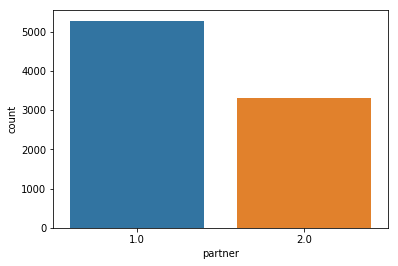

In [6]:
sns.countplot(df['partner'])

In [7]:
df = df[df['partner'].notnull()]

In [8]:
df['partner'].unique()

array([1., 2.])

#### 1.2 - Missing Data
Strangely, although there is a value specifically for no response, they come as missing values.  I can fill those in now for respondents view of others, happiness, social activity, gender, and partner status.

In [9]:
print(tabulate([[col, df[col].isnull().sum()]for col in df.columns if df[col].isnull().sum() > 0], headers = ['Feature', 'Num Missing Rows']))

Feature      Num Missing Rows
---------  ------------------
tvtot                       8
ppltrst                    14
pplfair                    38
pplhlp                     25
happy                      31
sclmeet                    15
sclact                     93
gndr                       10
agea                      239


In [10]:
df['ppltrst'] = df['ppltrst'].fillna(99)
df['pplfair'] = df['pplfair'].fillna(99)
df['pplhlp'] = df['pplhlp'].fillna(99)
df['happy'] = df['happy'].fillna(99)
df['sclmeet'] = df['sclmeet'].fillna(99)

df['sclact'] = df['sclact'].fillna(9)
df['gndr'] = df['gndr'].fillna(9)

Before I start imputating ages, I'd like to take a closer look.  The distribution plot shows that ages have a bimodal model, with a peak at ~25 and another at ~55.  This can be explained because this is a longitudinal study, so data is collected intermittently over the years.  Below is an example of respondent number 26.  We see that their first survey was when they were 24 and the last survey at 49, giving a range of 25 years.  These 25 years matches the range between the peaks of the distribution plot.  It should be noted that the ranges between each survey for respondent can vary greatly; some are as small as 3 years.  

The box plot also shows that there is a potential outlier in age.  The right whisker goes a little past 100, which is rare but not unheard of to hear of people living past 100.  However, there is a data point that indicates a respondent was 114 years old. Its possible, since the oldest recorded person was 122, but highly unlikely.  Since there is only one age that is an outlier, I will remove it.  Winsorizing changes too many data points for my liking.  

C:\Users\Crystal\AppData\Local\Continuum\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


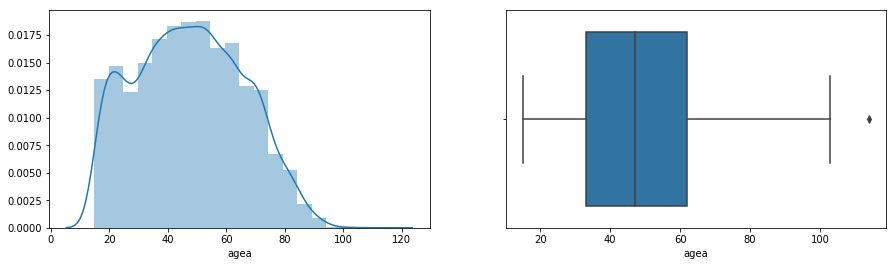

In [11]:
fig, (axis1, axis2) = plt.subplots(1, 2, figsize=(15, 4))

sns.distplot(df[df['agea'].notnull()]['agea'], bins = 20, ax =axis1)
sns.boxplot(x = 'agea', data = df, ax = axis2)

In [12]:
df[df['idno']==26]

,cntry,idno,year,tvtot,ppltrst,pplfair,pplhlp,happy,sclmeet,sclact,gndr,agea,partner
2,CH,26.0,6,1.0,8.0,8.0,8.0,7.0,6.0,3.0,1.0,24.0,2.0
775,CH,26.0,7,3.0,8.0,8.0,6.0,8.0,7.0,5.0,2.0,49.0,2.0


In [13]:
df = df[df['agea']<110]

To fill in the missing data in tv viewing time and age, I will implement the package fancyimpute.  There are three methods I'd like to test with fancyimpute: IterativeImputer, KNN, and SoftImpute.  Note that KNN and SoftImpute don't have a transform function, so I fit transformed the test set.  

In [14]:
dummy_df = pd.DataFrame()
dummy_df = pd.concat([dummy_df, pd.get_dummies(df['cntry'], prefix='cntry', drop_first=True)], axis = 1)

df = pd.concat([df, dummy_df], axis = 1)
X = df.drop(['partner', 'cntry'], axis = 1)
y = df['partner']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
imputer = fancyimpute.IterativeImputer(verbose=0)
X_train_imputer = pd.DataFrame(imputer.fit_transform(X_train), columns = X_train.columns)
X_test_imputer = pd.DataFrame(imputer.transform(X_test), columns = X_test.columns)

X_train_imputer['agea'] = X_train_imputer['agea'].apply(lambda x: round(x))
X_train_imputer['tvtot'] = X_train_imputer['tvtot'].apply(lambda x: round(x))

X_test_imputer['agea'] = X_test_imputer['agea'].apply(lambda x: round(x))
X_test_imputer['tvtot'] = X_test_imputer['tvtot'].apply(lambda x: round(x))

In [16]:
knn = fancyimpute.KNN(verbose=0)
X_train_knn = pd.DataFrame(knn.fit_transform(X_train), columns = X_train.columns)
X_test_knn = pd.DataFrame(knn.fit_transform(X_test), columns = X_test.columns)

X_train_knn['agea'] = X_train_knn['agea'].apply(lambda x: round(x))
X_train_knn['tvtot'] = X_train_knn['tvtot'].apply(lambda x: round(x))

X_test_knn['agea'] = X_test_knn['agea'].apply(lambda x: round(x))
X_test_knn['tvtot'] = X_test_knn['tvtot'].apply(lambda x: round(x))

In [17]:
softimpute = fancyimpute.SoftImpute(verbose=0)
X_train_softimpute = pd.DataFrame(softimpute.fit_transform(X_train), columns = X_train.columns)
X_test_softimpute = pd.DataFrame(softimpute.fit_transform(X_test), columns = X_test.columns)

X_train_softimpute['agea'] = X_train_softimpute['agea'].apply(lambda x: round(x))
X_train_softimpute['tvtot'] = X_train_softimpute['tvtot'].apply(lambda x: round(x))

X_test_softimpute['agea'] = X_test_softimpute['agea'].apply(lambda x: round(x))
X_test_softimpute['tvtot'] = X_test_softimpute['tvtot'].apply(lambda x: round(x))

C:\Users\Crystal\AppData\Local\Continuum\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


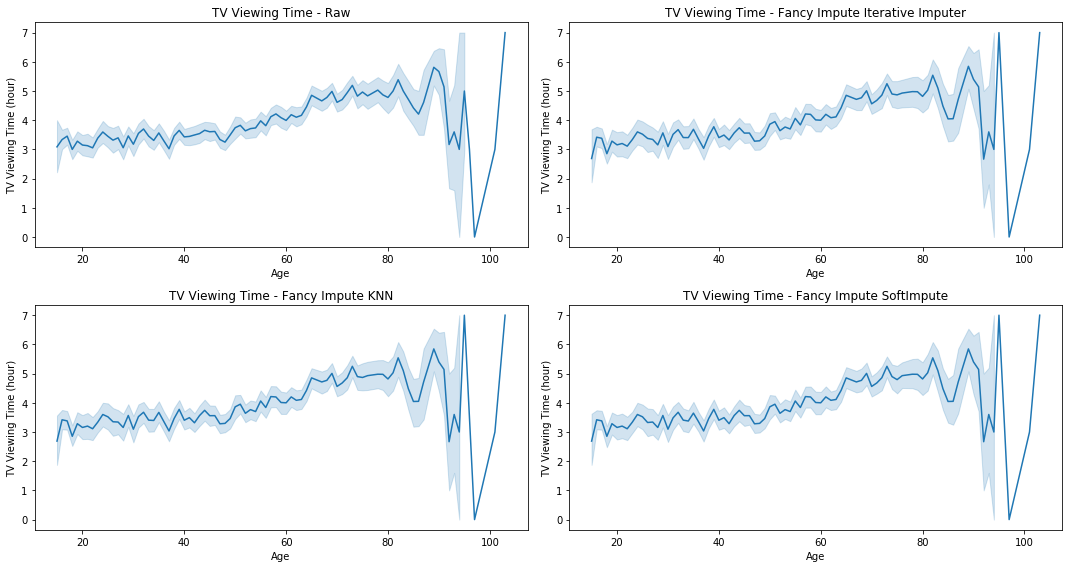

In [76]:
fig, ((axis1, axis2), (axis3, axis4)) = plt.subplots(2, 2, figsize=(15, 8))

sns.lineplot(x = 'agea', y = 'tvtot', data = df[df.notnull()], ax = axis1)
sns.lineplot(x = 'agea', y = 'tvtot', data = X_train_imputer, ax = axis2)
sns.lineplot(x = 'agea', y = 'tvtot', data = X_train_knn, ax = axis3)
sns.lineplot(x = 'agea', y = 'tvtot', data = X_train_softimpute, ax = axis4)

axis1.set_title('TV Viewing Time - Raw')
axis2.set_title('TV Viewing Time - Fancy Impute Iterative Imputer')
axis3.set_title('TV Viewing Time - Fancy Impute KNN')
axis4.set_title('TV Viewing Time - Fancy Impute SoftImpute')

for ax in [axis1, axis2, axis3, axis4]:
    ax.set_ylabel('TV Viewing Time (hour)')
    ax.set_xlabel('Age')
plt.tight_layout()

#### 1.3 - Baseline Model
Since I have three methods of imputation, I wanted to get a baseline model and narrow it down to one method before I go to optimizing the model.  The summary of the accuracies and F1 scores for the training and test set are summarized below.  For the most part, all three methods have the same result.  The only exception is the first method, which has a slightly lower training accuracy.  Going forward, I will use the imputed data from the iterative imputer method as it gets similar results but has less overfitting.

| Model | Training Accuracy   |Test Accuracy   |Training F1 score 1,2   |Test F1 score 1,2   |
|------|------|
|   fancyimpute - Imputer  | 0.78   |0.76   |0.84, 0.67  |0.82, 0.64  | 
|   fancyimpute - knn  | 0.79   |0.76   |0.84, 0.67   |0.82, 0.64  | 
|   fancyimpute - SoftImpute  |  0.79   |0.76   |0.84, 0.67  |0.82, 0.64   | 

In [19]:
baseline_params = {'n_estimators': 500,
          'max_depth': 2,
          'loss': 'deviance'}

In [20]:
baseline_imputer = ensemble.GradientBoostingClassifier(**baseline_params)
baseline_imputer.fit(X_train_imputer, y_train)

predict_train_imputer = baseline_imputer.predict(X_train_imputer)
predict_test_imputer = baseline_imputer.predict(X_test_imputer)

baseline_imputer_train_results = confusion_matrix(y_train, predict_train_imputer)
print('Baseline imputer training set report: ')
print(classification_report(y_train, predict_train_imputer))
print('\n')
print('Baseline imputer test set report: ')
print(classification_report(y_test, predict_test_imputer))


Baseline imputer training set report: 
              precision    recall  f1-score   support

         1.0       0.77      0.93      0.84      4089
         2.0       0.83      0.56      0.67      2580

    accuracy                           0.78      6669
   macro avg       0.80      0.74      0.75      6669
weighted avg       0.79      0.78      0.77      6669



Baseline imputer test set report: 
              precision    recall  f1-score   support

         1.0       0.76      0.89      0.82      1023
         2.0       0.76      0.55      0.64       645

    accuracy                           0.76      1668
   macro avg       0.76      0.72      0.73      1668
weighted avg       0.76      0.76      0.75      1668



In [21]:
baseline_knn = ensemble.GradientBoostingClassifier(**baseline_params)
baseline_knn.fit(X_train_knn, y_train)

predict_train_knn = baseline_knn.predict(X_train_knn)
predict_test_knn = baseline_knn.predict(X_test_knn)

baseline_knn_train_results = confusion_matrix(y_train, predict_train_knn)
print('Baseline knn training set report: ')
print(classification_report(y_train, predict_train_knn))
print('\n')
print('Baseline knn test set report: ')
print(classification_report(y_test, predict_test_knn))


Baseline knn training set report: 
              precision    recall  f1-score   support

         1.0       0.77      0.93      0.84      4089
         2.0       0.83      0.56      0.67      2580

    accuracy                           0.79      6669
   macro avg       0.80      0.75      0.76      6669
weighted avg       0.79      0.79      0.78      6669



Baseline knn test set report: 
              precision    recall  f1-score   support

         1.0       0.76      0.89      0.82      1023
         2.0       0.75      0.55      0.64       645

    accuracy                           0.76      1668
   macro avg       0.76      0.72      0.73      1668
weighted avg       0.76      0.76      0.75      1668



In [22]:
baseline_softimpute = ensemble.GradientBoostingClassifier(**baseline_params)
baseline_softimpute.fit(X_train_softimpute, y_train)

predict_train_softimpute = baseline_knn.predict(X_train_softimpute)
predict_test_softimpute = baseline_knn.predict(X_test_softimpute)

baseline_knn_train_results = confusion_matrix(y_train, predict_train_softimpute)
print('Baseline soft impute training set report: ')
print(classification_report(y_train, predict_train_softimpute))
print('\n')
print('Baseline soft impute test set report: ')
print(classification_report(y_test, predict_test_softimpute))


Baseline soft impute training set report: 
              precision    recall  f1-score   support

         1.0       0.77      0.93      0.84      4089
         2.0       0.83      0.56      0.67      2580

    accuracy                           0.79      6669
   macro avg       0.80      0.75      0.76      6669
weighted avg       0.79      0.79      0.78      6669



Baseline soft impute test set report: 
              precision    recall  f1-score   support

         1.0       0.76      0.89      0.82      1023
         2.0       0.75      0.55      0.64       645

    accuracy                           0.76      1668
   macro avg       0.76      0.72      0.73      1668
weighted avg       0.76      0.76      0.75      1668



### 2 - Data Exploration & Feature Engineering
The features can be split into three main categories:  social, self reporting, and view of others.  The social aspect concerns how often the respondent meet with others and how often the respondent thinks they take part in social activities compared to their peers.  The self reporting category deals with how happy the respondent is, their age, and how many hours they watch tv.  Lastly, the view of others is how helpful, trustworthy, and fair the respondent thought other people were.  

#### 2.1 - Social Aspects
Below are histograms of how often respondents meet friends/colleagues/family (left) and how often they attend social events (right), excluding results where the respondent did not answer.  Most people meet friends several times a week (category 6), although a good number of them also meet up anywhere from several times a month to everyday (categories 4, 5, and 7).  On the right, most people think they attend social gatherings about the same as someone of the similar age (category 3).  

C:\Users\Crystal\AppData\Local\Continuum\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


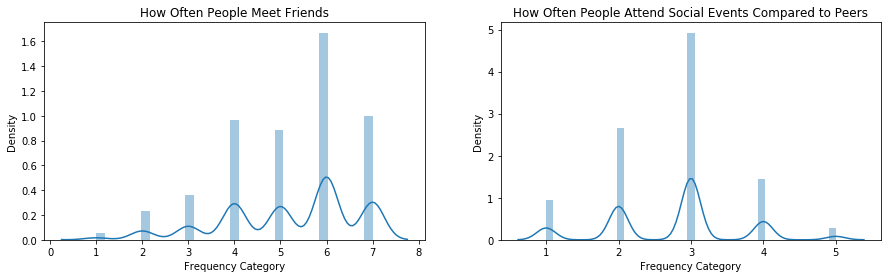

In [80]:
fig, (axis1, axis2) = plt.subplots(1, 2, figsize=(15, 4))

sns.distplot(df[df['sclmeet']<99]['sclmeet'], ax = axis1)
sns.distplot(df[df['sclact']<9]['sclact'], ax = axis2)

axis1.set_title('How Often People Meet Friends')
axis2.set_title('How Often People Attend Social Events Compared to Peers')

for ax in [axis1, axis2]:
    ax.set_ylabel('Density')
    ax.set_xlabel('Frequency Category')

Below I've plotted each social category, but showing if respondents have partners or not.  It seems those without partners are at the two extremes of how often they meet with others - either they never meet with anyone at all, or meet at least several times a week.  Similarly, those without partners think they attend social events either much less than most or more than most.  

To simplify the feature of how often respondents meet, I've split respondents into 4 categories:  low, medium, high, for how often they meet (1, 2, and 3 respectively), with a fourth category of did not respond.  I left the social activities feature alone.

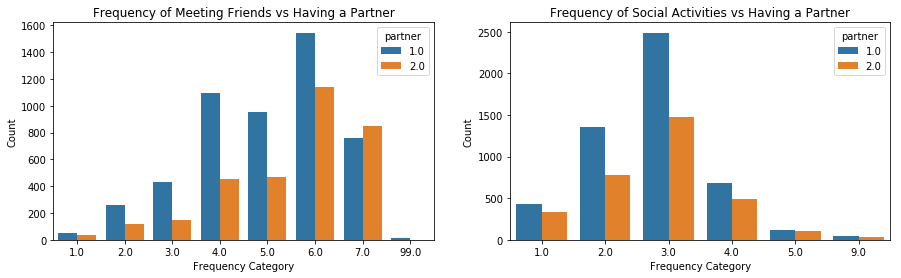

In [90]:
fig, (axis1, axis2) = plt.subplots(1, 2, figsize=(15, 4))

sns.countplot(x = 'sclmeet', hue = 'partner', data = df, ax = axis1)
sns.countplot(x = 'sclact', hue = 'partner', data = df, ax = axis2)

axis1.set_title('Frequency of Meeting Friends vs Having a Partner')
axis2.set_title('Frequency of Social Activities vs Having a Partner')

for ax in [axis1, axis2]:
    ax.set_ylabel('Count')
    ax.set_xlabel('Frequency Category')

In [24]:
sclmeet_dict = {1.0: 1, 2.0: 1, 3.0: 1, 4.0: 2, 5.0: 2, 6.0: 3, 7.0: 3, 99.0: 9}

In [26]:
X_train_imputer['sclmeet_cat'] = X_train_imputer['sclmeet'].apply(lambda x: sclmeet_dict[x])
X_test_imputer['sclmeet_cat'] = X_test_imputer['sclmeet'].apply(lambda x: sclmeet_dict[x])

#### 2.2 - Self Reporting
People self reported how happy they felt, how many hours they watch tv during the weekdays, and their age at the time of the survey.  Most people felt they were happy, and people watched 2-5 hrs of tv per week.  Age has been discussed in detail above, but briefly, there is a bimodal model in age, possibly because this is a longitudinal study and there can be as much as 30 years in between each survey, which corresponds with the difference in the two peaks.   

C:\Users\Crystal\AppData\Local\Continuum\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


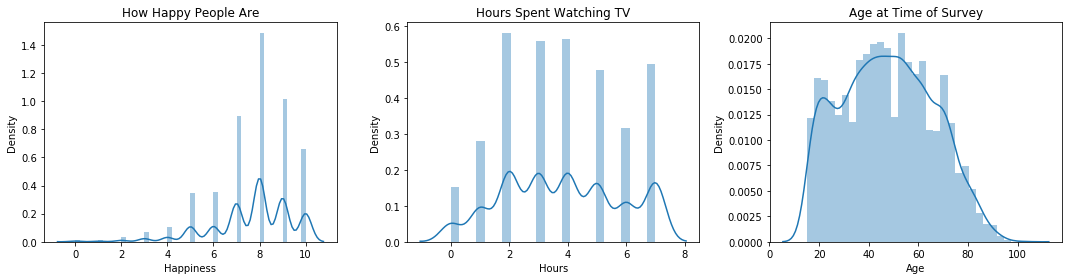

In [91]:
fig, (axis1, axis2, axis3) = plt.subplots(1, 3, figsize=(15, 4))

sns.distplot(df[df['happy']<99]['happy'], ax = axis1)
sns.distplot(df[df['tvtot'].notnull()]['tvtot'], ax = axis2)
sns.distplot(df['agea'], ax = axis3)

axis1.set_title('How Happy People Are')
axis2.set_title('Hours Spent Watching TV')
axis3.set_title('Age at Time of Survey')

for ax in [axis1, axis2, axis3]:
    ax.set_ylabel('Density')
    
axis1.set_xlabel('Happiness')
axis2.set_xlabel('Hours')
axis3.set_xlabel('Age')
plt.tight_layout()

Below are breakdowns of happiness, tv watching, and age with if the respondents have partners or not.  Its pretty clear that happiness is related to having a partner or not.  Those without partners seem to watch less tv.  This makes sense as these people are most likely out socializing instead of staying in.  Lastly, and unsurprisingly, younger people are more likely to not have partners.  

Again, I've created some form of low/med/high categories for each of these features.  For age, this corresponds more to young, middle aged, senior, and super senior.  

C:\Users\Crystal\AppData\Local\Continuum\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


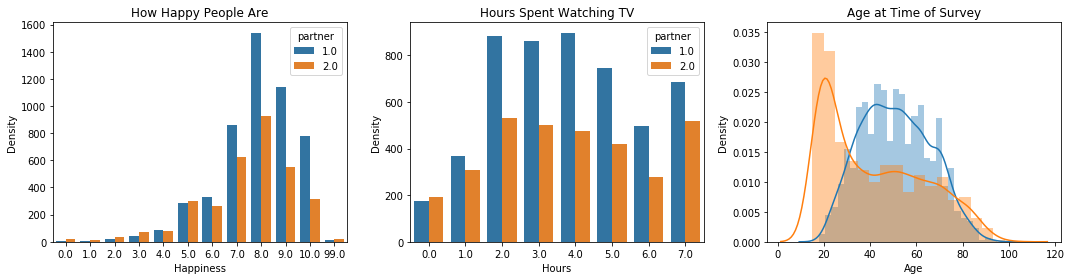

In [94]:
fig, (axis1, axis2, axis3) = plt.subplots(1, 3, figsize=(15, 4))

sns.countplot(x = 'happy', hue = 'partner', data = df, ax = axis1)
sns.countplot(x = 'tvtot', hue = 'partner', data = df, ax = axis2)
sns.distplot(df[df['partner']==1]['agea'], ax = axis3)
sns.distplot(df[df['partner']==2]['agea'], ax = axis3)


axis1.set_title('How Happy People Are')
axis2.set_title('Hours Spent Watching TV')
axis3.set_title('Age at Time of Survey')

for ax in [axis1, axis2, axis3]:
    ax.set_ylabel('Density')
    
axis1.set_xlabel('Happiness')
axis2.set_xlabel('Hours')
axis3.set_xlabel('Age')
plt.tight_layout()

In [29]:
happy_dict = {0.0: 1, 1.0: 1, 2.0: 1, 3.0: 1, 4.0: 1, 5.0: 2, 6.0: 2, 7.0: 2, 8.0: 3, 
              9.0: 3, 10.0: 3, 99.0: 9}

In [30]:
tvtot_dict = {0.0: 1, 1.0: 1, 2.0: 2, 3.0: 2, 4.0: 2, 5.0: 3, 6.0: 3, 7.0: 3}

In [31]:
def convert_age(col):
    if col < 35:
        return 1
    if col >= 75: 
        return 4
    if 35 <= col < 65:
        return 2
    if 65 <= col < 75:
        return 3

In [32]:
X_train_imputer['happy_cat'] = X_train_imputer['happy'].apply(lambda x: happy_dict[x])
X_test_imputer['happy_cat'] = X_test_imputer['happy'].apply(lambda x: happy_dict[x])

In [33]:
X_train_imputer['tvtot_cat'] = X_train_imputer['tvtot'].apply(lambda x: tvtot_dict[x])
X_test_imputer['tvtot_cat'] = X_test_imputer['tvtot'].apply(lambda x: tvtot_dict[x])

In [34]:
X_train_imputer['agea_cat'] = X_train_imputer['agea'].apply(convert_age)
X_test_imputer['agea_cat'] = X_test_imputer['agea'].apply(convert_age)

#### 2.3 - View of Others
Lastly, we see how respondents view others in terms of fairness, helpfulness, and trust.  There isn't much variation in these features as the peaks for all three features are between 5-8.  Again, I will be creating low/med/high categories for these features. 

In [ ]:
fig, (axis1, axis2, axis3) = plt.subplots(1, 3, figsize=(15, 4))

sns.distplot(df[df['pplfair']<99]['pplfair'], ax = axis1)
sns.distplot(df[df['pplhlp']<99]['pplhlp'], ax = axis2)
sns.distplot(df[df['ppltrst']<99]['ppltrst'], ax = axis3)

axis1.set_title('Percieved Fairness of Others')
axis2.set_title('Percieved Helpfulness of Others')
axis1.set_title('Percieved Trustworthiness of Others')

for ax in [axis1, axis2, axis3]:
    ax.set_ylabel('Density')
    ax.set_xlabel('Level')
plt.tight_layout()

In [36]:
ppl_dict = {0.0: 1, 1.0: 1, 2.0: 1, 3.0: 1, 4.0: 1, 5.0: 2, 6.0: 2, 7.0: 2, 8.0: 2, 
            9.0: 3, 10.0: 3, 99.0: 9}

In [37]:
X_train_imputer['pplfair_cat'] = X_train_imputer['pplfair'].apply(lambda x: ppl_dict[x])
X_train_imputer['pplhlp_cat'] = X_train_imputer['pplhlp'].apply(lambda x: ppl_dict[x])
X_train_imputer['ppltrst_cat'] = X_train_imputer['ppltrst'].apply(lambda x: ppl_dict[x])

X_test_imputer['pplfair_cat'] = X_test_imputer['pplfair'].apply(lambda x: ppl_dict[x])
X_test_imputer['pplhlp_cat'] = X_test_imputer['pplhlp'].apply(lambda x: ppl_dict[x])
X_test_imputer['ppltrst_cat'] = X_test_imputer['ppltrst'].apply(lambda x: ppl_dict[x])

### 3 - Baseline Model
Now that I have some new features, lets use the same baseline parameters as before and build a model.  Unfortunately, accuracy and f1 scores are pretty much the same as the previous model I built.  

In [38]:
baseline_clr = ensemble.GradientBoostingClassifier(**baseline_params)
baseline_clr.fit(X_train_imputer, y_train)

predict_train_imputer = baseline_clr.predict(X_train_imputer)
predict_test_imputer = baseline_clr.predict(X_test_imputer)

baseline_clr_train_results = confusion_matrix(y_train, predict_train_imputer)
print('Baseline imputer training set report: ')
print(classification_report(y_train, predict_train_imputer))
print('\n')
print('Baseline imputer test set report: ')
print(classification_report(y_test, predict_test_imputer))


Baseline imputer training set report: 
              precision    recall  f1-score   support

         1.0       0.77      0.93      0.84      4089
         2.0       0.83      0.56      0.67      2580

    accuracy                           0.78      6669
   macro avg       0.80      0.74      0.75      6669
weighted avg       0.79      0.78      0.77      6669



Baseline imputer test set report: 
              precision    recall  f1-score   support

         1.0       0.76      0.89      0.82      1023
         2.0       0.76      0.55      0.64       645

    accuracy                           0.76      1668
   macro avg       0.76      0.72      0.73      1668
weighted avg       0.76      0.76      0.75      1668



The cool thing about this model is that it calculates which features are most important.  Below is a chart displaying the top 10 most important features.  By far, age is the most important feature, followed by happiness, id number, and gender.  A lot of the other features have extremely low importance values; can we remove these 'unimportant' features?

To test this, I kept the top 6 most important features and ran the model again with baseline parameters.  Accuracy stays the same although f1 scores decreases slightly when predicting 'no partner'.  Although the f1 score is slightly decreased, the model is much cleaner and I will try to improve upon this 6-feature model.

| Model | Training Accuracy   |Test Accuracy   |Training F1 score 1,2   |Test F1 score 1,2   |
|------|------|
|   Baseline Model  | 0.78   |0.76   |0.84, 0.67  |0.82, 0.64  | 
|   Important Features Model  | 0.78   |0.76   |0.84, 0.65  |0.82, 0.63  | 

In [39]:
feat_importance_data = list(zip(baseline_clr.feature_importances_*100, X_train_imputer.columns))
feat_importance_df = pd.DataFrame(feat_importance_data, columns = ['Feature Importance', 'Feature Name'])

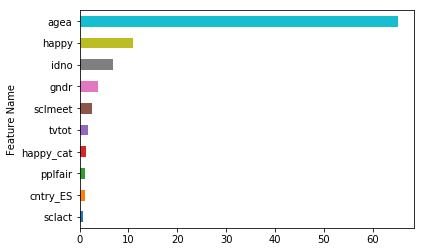

In [40]:
feat_importance_df.sort_values(by = ['Feature Importance'], ascending=True, inplace = True)
feat_importance_df[-10:].plot(x = 'Feature Name', y = 'Feature Importance', kind = 'barh', legend = False)


In [41]:
col_important = ['agea', 'happy', 'idno', 'gndr', 'sclmeet', 'tvtot']
X_train_2 = X_train_imputer[col_important]
X_test_2 = X_test_imputer[col_important]

In [42]:
baseline_clr = ensemble.GradientBoostingClassifier(**baseline_params)
baseline_clr.fit(X_train_2, y_train)

predict_train_imputer = baseline_clr.predict(X_train_2)
predict_test_imputer = baseline_clr.predict(X_test_2)

baseline_clr_train_results = confusion_matrix(y_train, predict_train_imputer)
print('Baseline imputer training set report: ')
print(classification_report(y_train, predict_train_imputer))
print('\n')
print('Baseline imputer test set report: ')
print(classification_report(y_test, predict_test_imputer))


Baseline imputer training set report: 
              precision    recall  f1-score   support

         1.0       0.76      0.93      0.84      4089
         2.0       0.83      0.54      0.65      2580

    accuracy                           0.78      6669
   macro avg       0.79      0.73      0.74      6669
weighted avg       0.79      0.78      0.77      6669



Baseline imputer test set report: 
              precision    recall  f1-score   support

         1.0       0.75      0.90      0.82      1023
         2.0       0.78      0.53      0.63       645

    accuracy                           0.76      1668
   macro avg       0.76      0.72      0.73      1668
weighted avg       0.76      0.76      0.75      1668



### 4 - Improving the Model
The lecture gives some tips on how to improve the model, including subsampling, loss functions, and optimizing hyperparameters.  To optimize each parameter one by one would be time consuming, so I will utilize a random grid search to give me a starting point.

#### 4.1 - Random Grid
Here I will go through what each hyperparameter is.  Estimators is the number of trees, which I have set as a range between 100 and 1000 incremented by 50.  Loss is the loss function. In this case, there are two: exponential and deviance.  Max depth is how deep the tree will go, which I have set between 2 and 10, and max features is the number of features to consider when splitting, which I have set between 2-8 as a starting point.  Min sample split is the minimum number of samples required to split in a node, and min sample leaf is the minimum number of leaves to be at a leaf node.  Both of tehse I have a range between 2-20.  Lastly is the subsampling rate, which is the fraction of the data the model will.   

In [60]:
random_grid = {
 'n_estimators': np.arange(100, 1050, 50),
 'loss': ['exponential', 'deviance'],
 'max_depth': np.arange(2, 10),
 'max_features': np.arange(2, 8, 2),
 'learning_rate': np.arange(0.1, 1.1, 0.1),
 'min_samples_split': [2,5,7,10,12,15,17,20],
 'min_samples_leaf': [2,5,7,10,12,15,17,20],
 'subsample': np.arange(0.1, 1.1, 0.1),
 'random_state': [42]}

With this range of parameters, the best mean accuracy of the training set is 81%, and the best parameters found are below.  

In [61]:
gb_clr =  ensemble.GradientBoostingClassifier()
gb_rand = RandomizedSearchCV(gb_clr, random_grid)
best_gb_rand = gb_rand.fit(X_train_2, y_train)
print('Mean accuracy of random grid search: {}'.format(best_gb_rand.score(X_train_2, y_train)))


C:\Users\Crystal\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Mean accuracy of random grid search: 0.8107662318188634


In [62]:
best_gb_rand.best_params_


{'learning_rate': 0.2,
 'loss': 'exponential',
 'max_depth': 3,
 'max_features': 2,
 'min_samples_leaf': 2,
 'min_samples_split': 10,
 'n_estimators': 500,
 'random_state': 42,
 'subsample': 0.9}

#### 4.2 - Grid Search
The random grid search gave me a good starting point.  Now i need to use the grid search to pinpoint the best parameters.  Due to high computational times, I had to optimize the parameters on a subset of the original data.  In the end, with the optimized parameters, I got a mean accuracy of 78%.

In [63]:
X_train_2 = X_train_2.reset_index(drop = True)
y_train = y_train.reset_index(drop = True)
df2 = pd.concat([X_train_2, y_train], axis = 1)
df2_sub = df2.sample(frac = 0.25, random_state=42)

X_train_2_sub = df2_sub.drop('partner', axis = 1)
y_train_sub = df2_sub['partner']

In [68]:
param_grid = {
 'learning_rate': [0.05, 0.1],
 'max_depth': [2, 3, 4, 5],
 'max_features': [2, 3, 4, 5],
 'min_samples_leaf': [2, 3, 4, 5],
 'min_samples_split': [10, 11, 12, 13],
 'n_estimators': [300, 400, 500],
 'random_state': [42],
 'subsample': [0.9]}

In [69]:
gb_grid = GridSearchCV(gb_clr, param_grid)
best_gb_grid = gb_grid.fit(X_train_2_sub, y_train_sub)
print('Mean accuracy of grid search: {}'.format(best_gb_grid.score(X_train_2_sub, y_train_sub)))

C:\Users\Crystal\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Mean accuracy of grid search: 0.7834433113377325


In [70]:
best_gb_grid.best_params_

{'learning_rate': 0.05,
 'max_depth': 2,
 'max_features': 2,
 'min_samples_leaf': 2,
 'min_samples_split': 12,
 'n_estimators': 400,
 'random_state': 42,
 'subsample': 0.9}

#### 4.3 - Best Parameters
Finally, after applying the best parameters to the dataset, the accuracy decreased for the training set, but stayed the same for the test set.  Although I was not able to increase accuracy, the model is much cleaner and I have reduced overfitting between the training and test sets.

| Model | Training Accuracy   |Test Accuracy   |Training F1 score 1,2   |Test F1 score 1,2   |
|------|------|
|   Baseline Model  | 0.78   |0.76   |0.84, 0.67  |0.82, 0.64  | 
|   Important Features Model  | 0.78   |0.76   |0.84, 0.65  |0.82, 0.63  | 
|   Best Model  | 0.76   |0.76   |0.83, 0.62  |0.83, 0.63  | 

In [74]:
best_clr = ensemble.GradientBoostingClassifier(**best_gb_grid.best_params_)
best_clr.fit(X_train_2, y_train)

predict_train_imputer = best_clr.predict(X_train_2)
predict_test_imputer = best_clr.predict(X_test_2)

best_clr_train_results = confusion_matrix(y_train, predict_train_imputer)
print('Final training set report: ')
print(classification_report(y_train, predict_train_imputer))
print('\n')
print('Final test set report: ')
print(classification_report(y_test, predict_test_imputer))


Final training set report: 
              precision    recall  f1-score   support

         1.0       0.75      0.93      0.83      4089
         2.0       0.82      0.50      0.62      2580

    accuracy                           0.76      6669
   macro avg       0.78      0.72      0.73      6669
weighted avg       0.77      0.76      0.75      6669



Final test set report: 
              precision    recall  f1-score   support

         1.0       0.75      0.91      0.83      1023
         2.0       0.79      0.52      0.63       645

    accuracy                           0.76      1668
   macro avg       0.77      0.72      0.73      1668
weighted avg       0.77      0.76      0.75      1668

